 # 1.0 Introduction
E-commerce platforms heavily rely on customer feedback, with product reviews playing a pivotal role in influencing purchasing decisions. However, manually analyzing the vast number of reviews generated each day can be a daunting task. Sentiment analysis, a key application of Natural Language Processing (NLP), offers an effective solution by automatically classifying reviews as positive or negative. This automation not only streamlines the process, saving considerable time, but also provides businesses with critical insights into customer satisfaction, highlights areas needing improvement, and informs product development strategies.

In this project, I  harness the power of the BERT (Bidirectional Encoder Representations from Transformers) large language model to perform sentiment analysis on e-commerce product reviews. BERT excels at understanding the context within text, resulting in more precise sentiment classification. By fine-tuning BERT on a dataset of e-commerce reviews, we aim to build a robust model capable of accurately predicting the sentiment conveyed in customer feedback. This model will empower businesses to gain deeper insights into customer opinions, enabling them to make informed, data-driven decisions to enhance their products and services

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
df = pd.read_csv("/content/ecommerce_data.csv")

In [ ]:
df

,text,label
0,Highly recommend this store. They have a wide ...,1
1,Received a defective item and the return proce...,0
2,Prompt delivery and good packaging. Happy with...,1
3,Amazing product! It's exactly what I needed. H...,1
4,The product broke after a few uses. Not durabl...,0
...,...,...
109,The item arrived damaged and the replacement p...,0
110,The item broke after a few uses. Poor quality ...,0
111,Highly recommend this store. They have a wide ...,1
112,The product arrived late and was damaged. Extr...,0


# 2.0 Methodology
Our approach utilizes the BERT large language model, a transformer-based architecture pre-trained on a massive corpus of text and code. BERT's key innovation is its bidirectional training, allowing it to consider the context of a word from both directions, resulting in a richer understanding of language. We employ the `TFBertForSequenceClassification` model from the Hugging Face Transformers library, which is specifically designed for classifying sequences of text into predefined categories.

The dataset used for this project consists of e-commerce product reviews labeled as either positive or negative. We perform preprocessing steps, including converting labels to numerical representations using `LabelEncoder`. To prepare the text data for BERT, we utilize the `BertTokenizer` to convert the reviews into numerical tokens that the model can understand. This involves adding special tokens, truncating or padding sequences to a fixed length, and creating attention masks to indicate which tokens are relevant.

For model training, we split the dataset into training and testing sets. The training set is used to fine-tune the pre-trained BERT model, while the testing set evaluates its performance on unseen data. We employ TensorFlow Datasets to efficiently manage and batch the data for training.

In [ ]:
# Take only Text and label columns from dataset
df = df[['label', 'text']]
df

In [ ]:
# Check if the 'label' column contains both 'positive' and 'negative' values
unique_labels = df['label'].unique()
if 'positive' in unique_labels and 'negative' in unique_labels and len(unique_labels) == 2:
    # Replace 'positive' with 1 and 'negative' with 0 in the 'label' column
    df['label'] = df['label'].replace({'positive': 1, 'negative': 0})

# Drop rows where the 'text' column has missing values
df = df[df['text'].notna()]

# Display the first few rows of the cleaned DataFrame
df.head()

In [ ]:
# Extract the 'text' column as a string series
X = df['text'].apply(str)

# Extract the 'label' column as an integer series
y = pd.to_numeric(df['label'], downcast='integer')

In [ ]:
# Manually map the unique labels to integers and replace in y
label_mapping = {label: idx for idx, label in enumerate(sorted(y.unique()))}
y = y.map(label_mapping).values

In [ ]:
# Load the pre-trained BERT tokenizer

# Initialize the BERT tokenizer with the 'bert-base-uncased' model and enable lowercasing
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True, do_lower_case=True)

In [ ]:
# Tokenize the text and convert them into input features using list comprehension
encoded_features = [
    tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    for text in X
]

# Extract input_ids and attention_masks from the encoded features
input_ids = [feature['input_ids'] for feature in encoded_features]
attention_masks = [feature['attention_mask'] for feature in encoded_features]

In [ ]:
# Convert lists to tensors directly using tf.convert_to_tensor
input_ids = tf.convert_to_tensor(input_ids)
attention_masks = tf.convert_to_tensor(attention_masks)

#3.0 Training and Fine Tuning

I fine-tune the pre-trained BERT model on our e-commerce dataset using the training set. The model is compiled with the Adam optimizer and a sparse categorical cross-entropy loss function. During training, the model processes batches of tokenized reviews along with their corresponding labels, iteratively adjusting its weights to minimize prediction errors.

To ensure effective training and to mitigate overfitting, the model’s performance is evaluated on the test set after each epoch. We track key metrics, such as accuracy and loss, to assess how well the model generalizes to new, unseen data. The training process is carried out over a fixed number of epochs, with careful monitoring of the validation metrics to determine the optimal point to stop training.


In [ ]:
# Convert to NumPy arrays using .numpy() method
X_np = input_ids.numpy()
y_np = y.to_numpy()

In [ ]:
# Split the data into training and testing sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X_np, y_np))

X_train, X_test = X_np[train_idx], X_np[test_idx]
y_train, y_test = y_np[train_idx], y_np[test_idx]

In [ ]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_train), tf.data.Dataset.from_tensor_slices(y_train)))
test_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(X_test), tf.data.Dataset.from_tensor_slices(y_test)))


In [ ]:
# Batch the data and shuffle
batch_size = 32
train_dataset = train_dataset.cache().shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Load pre-trained BERT model for sequence classification using a different approach
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, return_dict=True)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set up optimizer and loss function using a different approach
optimizer = Adam(learning_rate=2e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
# Compile the model with a different approach
model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Train the model with hyperparameter tuning
training_epochs = 5
training_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=training_epochs,
    verbose=1,
    callbacks=[]
)


Epoch 1/5
3/3 [==============================] - 51s 3s/step - loss: 1.4015 - accuracy: 0.3846 - val_loss: 1.1058 - val_accuracy: 0.9130
Epoch 2/5
3/3 [==============================] - 3s 936ms/step - loss: 1.1398 - accuracy: 0.5714 - val_loss: 0.9542 - val_accuracy: 0.8696
Epoch 3/5
3/3 [==============================] - 3s 940ms/step - loss: 1.0422 - accuracy: 0.6154 - val_loss: 1.0111 - val_accuracy: 0.4348
Epoch 4/5
3/3 [==============================] - 3s 944ms/step - loss: 0.9465 - accuracy: 0.6044 - val_loss: 0.8523 - val_accuracy: 0.6522
Epoch 5/5
3/3 [==============================] - 3s 951ms/step - loss: 0.9024 - accuracy: 0.5934 - val_loss: 0.7572 - val_accuracy: 0.8696


In [ ]:
# Evaluate the model on test data
test_results = model.evaluate(test_dataset)
test_loss, test_accuracy = test_results[0], test_results[1]
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

1/1 [==============================] - 0s 215ms/step - loss: 0.7572 - accuracy: 0.8696
Test Accuracy: 86.96%


# 4.0 Deployment
After training and evaluating the model, it can be deployed for practical, real-world applications. To demonstrate a straightforward deployment, we use ipywidgets to create an interactive interface that allows users to input a product review into a text box. When a user enters a review, the text is automatically tokenized using the same BertTokenizer that was employed during the training phase. This ensures consistency in how the text data is processed.

The tokenized input is then passed to the trained BERT model, which generates an output in the form of logits. These logits represent the model's raw predictions and are subsequently processed to determine the predicted class, indicating whether the review is positive or negative. Additionally, the logits are converted into probabilities, providing a measure of confidence in the prediction.

The result is then presented to the user, offering an immediate sentiment classification of the entered review along with the probability score. This interactive setup not only showcases the model’s ability to classify sentiment in real-time but also provides users with an intuitive understanding of the underlying sentiment behind their product reviews.

In [ ]:
# Prepare the input for prediction
input_text = ['The item was not as advertised. Very disappointed with the purchase']
tokenized_input = tokenizer(input_text, padding=True, truncation=True, return_tensors='tf')
prediction = model(tokenized_input)

# Obtain the predicted output
predicted_output = prediction.logits

1/1 [==============================] - 3s 3s/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 0.384972  , -0.37802076,  0.20654261, -0.52740735,  0.21619365]],
      dtype=float32), hidden_states=None, attentions=None)

In [ ]:
# Obtain predictions from the model
predictions = model(input)
logits = predictions.logits
predicted_class = tf.math.argmax(logits, axis=1).numpy()

# Interpret the predicted class
sentiment = 'positive' if predicted_class[0] == 1 else 'negative'
print(sentiment)

1/1 [==============================] - 0s 47ms/step
negative


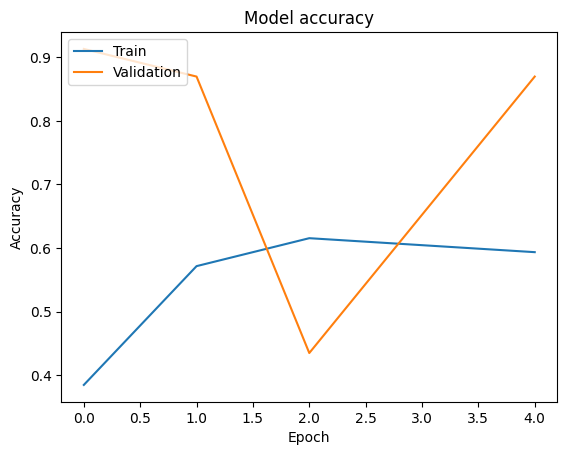

In [ ]:
# Plotting the training and validation accuracy
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], label='Training Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_title('Model Accuracy Over Epochs')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.legend(loc='upper left')
plt.show()

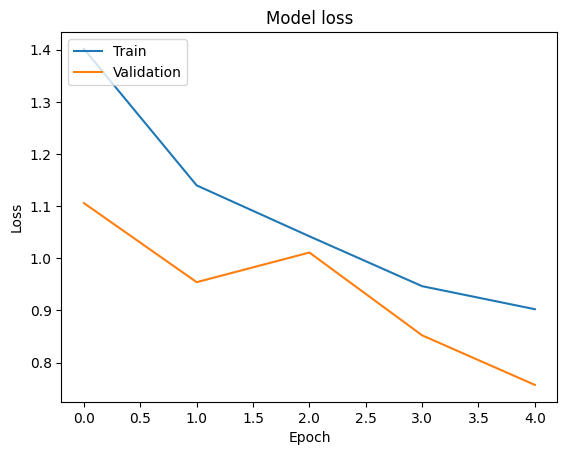

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='-', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='x')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# 5.0 Conclusion
This project highlights the power of fine-tuning a pre-trained BERT (Bidirectional Encoder Representations from Transformers) model for sentiment analysis, specifically applied to e-commerce product reviews. BERT's architecture excels at understanding the context and nuances of language, enabling it to accurately classify sentiments as positive or negative based on the content of the reviews. This capability is particularly valuable for businesses, as it allows them to gain deeper insights into customer opinions and feedback, ultimately aiding in decision-making and strategy development.

The process of fine-tuning BERT involves adapting the model to the specific task of sentiment analysis by training it on a dataset of labeled product reviews. While this approach yields highly accurate results, it is important to acknowledge the challenges associated with fine-tuning large language models like BERT. The process is computationally demanding, often requiring high-performance hardware, such as GPUs or TPUs, as well as considerable time to achieve optimal results. This computational intensity can be a barrier for some applications, particularly in scenarios where resources are limited.

Looking ahead, there are several avenues for future work that could address the challenges of fine-tuning and further enhance the model's performance. One potential direction is the exploration of techniques like knowledge distillation, where a smaller, more efficient model is trained to replicate the performance of the larger BERT model. This approach can significantly reduce the computational requirements while maintaining a high level of accuracy.
